After modifying the previous models to tackle the image classification problem, we began testing various values for the alpha and beta parameters. The experiments presented here were conducted on the MNIST dataset.

It turned out that, under the same conditions, all methods achieved nearly the same Test Accuracy on MNIST within 5 epochs. The cases discussed below include scenarios where alpha and beta are simple scalars, time-dependent vectors, time-dependent matrices, and time-dependent vectors that are transformed into matrices.

Using device: cpu
Starting training...
Epoch 1, Batch 0, Loss: 2.3049, Acc: 14.84%
Epoch 1, Batch 100, Loss: 0.6751, Acc: 70.93%
Epoch 1, Batch 200, Loss: 0.4883, Acc: 77.37%
Epoch 1, Batch 300, Loss: 0.5107, Acc: 80.40%
Epoch 1, Batch 400, Loss: 0.2964, Acc: 82.21%
Epoch 1 - Loss: 0.5913, Train Acc: 83.15%, Time: 960.49s
Alpha (horizontal diffusion): 1.6688
Beta (vertical diffusion): 2.6139
--------------------------------------------------------------------------------
Epoch 2, Batch 0, Loss: 0.3427, Acc: 89.84%
Epoch 2, Batch 100, Loss: 0.3682, Acc: 89.73%
Epoch 2, Batch 200, Loss: 0.3334, Acc: 90.19%
Epoch 2, Batch 300, Loss: 0.2646, Acc: 90.38%
Epoch 2, Batch 400, Loss: 0.2827, Acc: 90.65%
Epoch 2 - Loss: 0.3039, Train Acc: 90.80%, Time: 958.32s
Alpha (horizontal diffusion): 1.4278
Beta (vertical diffusion): 2.2954
--------------------------------------------------------------------------------
Epoch 3, Batch 0, Loss: 0.2562, Acc: 90.62%
Epoch 3, Batch 100, Loss: 0.2184, Acc: 92.2

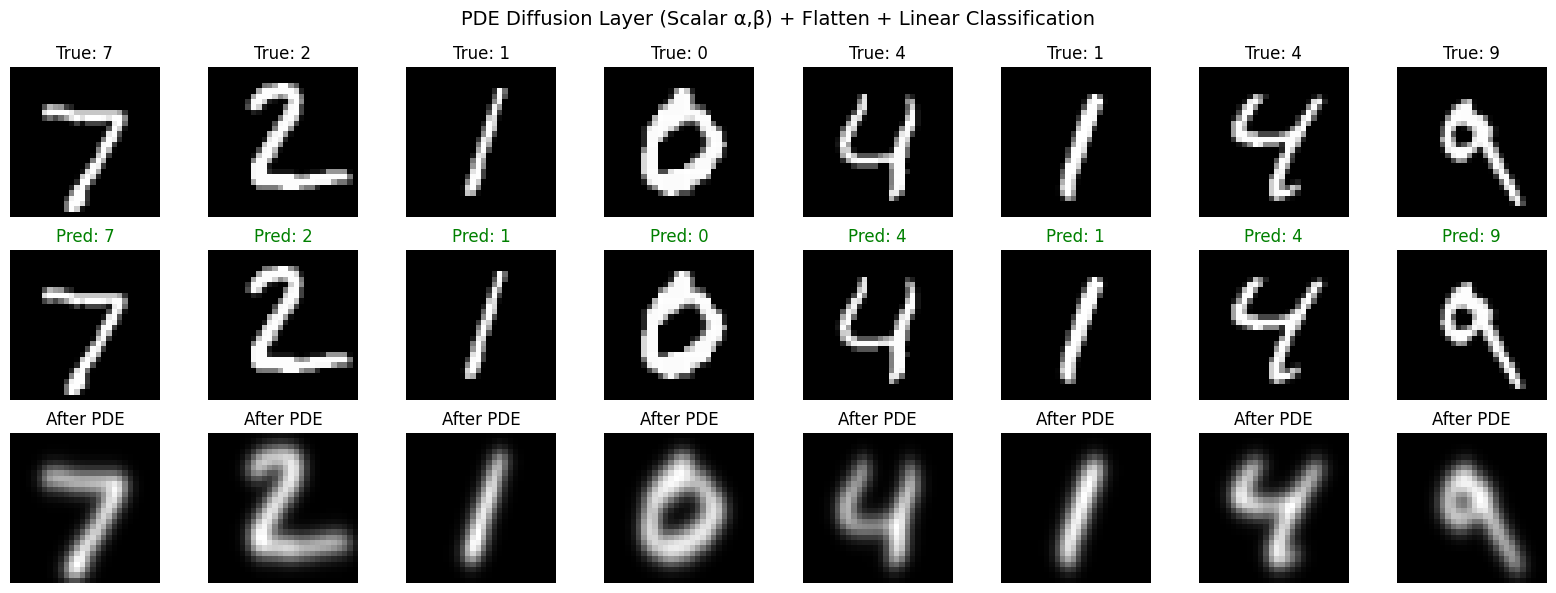

In [ ]:
# alpha and beta are scalars. Test Accuracy: 97.79%
# Alpha (horizontal diffusion coefficient): 1.0700
# Beta (vertical diffusion coefficient): 1.6373
# T = 0.01, dt = 0.005 and steps = 2. Two dense layers with RELU and 5 epochs.

# T = 1, dt = 0.1 and steps = 10. Test accuracy: 96.28%
#Alpha (horizontal diffusion coefficient): 0.8148 (moderate diffusion)
#Beta (vertical diffusion coefficient): 1.4029 (moderate diffusion)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Optimized PDE Diffusion Layer
class DiffusionLayer(nn.Module):
    def __init__(self, size=28, dt=0.1, dx=1.0, num_steps=10):  # Increased dt and added multiple steps
        super().__init__()
        self.size = size
        self.dt = dt
        self.dx = dx
        self.num_steps = num_steps  # Multiple diffusion steps

        # Initialize as scalar parameters instead of vectors
        self.alpha = nn.Parameter(torch.tensor(2.0))  # Single scalar value
        self.beta = nn.Parameter(torch.tensor(3.0))   # Single scalar value

    def forward(self, u):
        B, _, H, W = u.shape
        u = u.squeeze(1)

        # Apply multiple diffusion steps for more visible effect
        for step in range(self.num_steps):
            # Strang splitting: half step x, full step y, half step x
            u = self.diffuse_x_vectorized(u, self.alpha, self.dt / 2, self.dx)
            u = self.diffuse_y_vectorized(u, self.beta, self.dt, self.dx)
            u = self.diffuse_x_vectorized(u, self.alpha, self.dt / 2, self.dx)

        return u.unsqueeze(1)

    def diffuse_x_vectorized(self, u, alpha, dt, dx):
        """Vectorized diffusion in x-direction using batch Thomas solver"""
        B, H, W = u.shape

        # Compute coefficients - now alpha is a scalar, same for all rows
        a = -alpha * dt / dx**2  # Scalar
        b = 1 + 2 * alpha * dt / dx**2  # Scalar
        c = a  # Scalar

        # Process each row: u is (B, H, W), we want to solve along W dimension for each H
        # Reshape: (B, H, W) -> (B*H, W) to process all batch*row combinations
        u_reshaped = u.view(B * H, W)  # (B*H, W)

        # Expand scalar coefficients for all batch*row combinations
        a_expanded = a.expand(B * H)  # (B*H,) - same value for all
        b_expanded = b.expand(B * H)  # (B*H,)
        c_expanded = c.expand(B * H)  # (B*H,)

        # Solve all systems simultaneously
        result = self.thomas_solver_vectorized(a_expanded, b_expanded, c_expanded, u_reshaped)

        # Reshape back to (B, H, W)
        return result.view(B, H, W)

    def diffuse_y_vectorized(self, u, beta, dt, dx):
        """Vectorized diffusion in y-direction using batch Thomas solver"""
        B, H, W = u.shape

        # Compute coefficients - now beta is a scalar, same for all columns
        a = -beta * dt / dx**2  # Scalar
        b = 1 + 2 * beta * dt / dx**2  # Scalar
        c = a  # Scalar

        # Process each column: u is (B, H, W), we want to solve along H dimension for each W
        # Reshape: (B, H, W) -> (B*W, H) to process all batch*column combinations
        u_reshaped = u.transpose(1, 2).contiguous().view(B * W, H)  # (B*W, H)

        # Expand scalar coefficients for all batch*column combinations
        a_expanded = a.expand(B * W)  # (B*W,) - same value for all
        b_expanded = b.expand(B * W)  # (B*W,)
        c_expanded = c.expand(B * W)  # (B*W,)

        # Solve all systems simultaneously
        result = self.thomas_solver_vectorized(a_expanded, b_expanded, c_expanded, u_reshaped)

        # Reshape back to (B, H, W)
        return result.view(B, W, H).transpose(1, 2).contiguous()

    def thomas_solver_vectorized(self, a, b, c, d):
        """
        Vectorized Thomas algorithm for tridiagonal systems - gradient safe
        a, b, c: coefficients (shape: B,)
        d: right-hand side (shape: B, N)
        Returns: solution x (shape: B, N)
        """
        B, N = d.shape
        device = d.device

        # Expand scalar coefficients to match dimensions
        a = a.unsqueeze(1).expand(-1, N)  # (B, N)
        b = b.unsqueeze(1).expand(-1, N)  # (B, N)
        c = c.unsqueeze(1).expand(-1, N)  # (B, N)

        # Initialize arrays
        c_star = torch.zeros_like(d)
        d_star = torch.zeros_like(d)

        # Forward elimination - avoid in-place operations
        c_star_list = []
        d_star_list = []

        # First column
        c_star_0 = c[:, 0] / b[:, 0]
        d_star_0 = d[:, 0] / b[:, 0]
        c_star_list.append(c_star_0)
        d_star_list.append(d_star_0)

        # Forward sweep
        for i in range(1, N):
            denom = b[:, i] - a[:, i] * c_star_list[i-1]
            c_star_i = c[:, i] / denom
            d_star_i = (d[:, i] - a[:, i] * d_star_list[i-1]) / denom
            c_star_list.append(c_star_i)
            d_star_list.append(d_star_i)

        # Stack results
        c_star = torch.stack(c_star_list, dim=1)
        d_star = torch.stack(d_star_list, dim=1)

        # Back substitution - avoid in-place operations
        x_list = [None] * N
        x_list[-1] = d_star[:, -1]

        # Backward sweep
        for i in range(N-2, -1, -1):
            x_list[i] = d_star[:, i] - c_star[:, i] * x_list[i+1]

        # Stack results
        x = torch.stack(x_list, dim=1)

        return x

# Enhanced Neural Network
class PDEClassifier(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super().__init__()
        self.diff = DiffusionLayer()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.diff(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# Training Setup
transform = transforms.Compose([transforms.ToTensor()])
train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)
test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transform),
    batch_size=128, shuffle=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = PDEClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#Training Loop
print("Starting training...")
import time

for epoch in range(5):
    start_time = time.time()
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

    epoch_time = time.time() - start_time
    avg_loss = total_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Monitor alpha and beta parameters (now scalars)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Time: {epoch_time:.2f}s")
    print(f"Alpha (horizontal diffusion): {model.diff.alpha.item():.4f}")
    print(f"Beta (vertical diffusion): {model.diff.beta.item():.4f}")
    print("-" * 80)

print("Training completed!")

# --- Evaluation & Visualization ---
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.argmax(dim=1)
        test_correct += pred.eq(labels).sum().item()
        test_total += labels.size(0)

test_acc = 100. * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")

# Visualization
with torch.no_grad():
    images, labels = next(iter(test_loader))
    images = images.to(device)
    outputs = model(images)
    predicted = outputs.argmax(dim=1)

    # Show learned parameters
    print(f"\nLearned Parameters:")
    print(f"Alpha (horizontal diffusion coefficient): {model.diff.alpha.item():.4f}")
    print(f"Beta (vertical diffusion coefficient): {model.diff.beta.item():.4f}")
    print(f"\nWhat alpha and beta represent:")
    print(f"- Alpha: controls horizontal diffusion (same for all rows)")
    print(f"- Beta: controls vertical diffusion (same for all columns)")
    print(f"- Higher values = more diffusion/blurring in that direction")
    print(f"- Values around 1.0 are moderate, <0.5 is low diffusion, >2.0 is high diffusion")

    # Plot results
    images_cpu = images.cpu().numpy()
    preds_cpu = predicted.cpu().numpy()
    labels_cpu = labels.numpy()

    plt.figure(figsize=(16, 6))
    for i in range(8):
        # Original images
        plt.subplot(3, 8, i + 1)
        plt.imshow(images_cpu[i, 0], cmap='gray')
        plt.axis('off')
        plt.title(f"True: {labels_cpu[i]}")

        # Predictions
        plt.subplot(3, 8, i + 9)
        plt.imshow(images_cpu[i, 0], cmap='gray')
        plt.axis('off')
        color = 'green' if preds_cpu[i] == labels_cpu[i] else 'red'
        plt.title(f"Pred: {preds_cpu[i]}", color=color)

        # Diffused images
        plt.subplot(3, 8, i + 17)
        diffused = model.diff(images[i:i+1]).squeeze().cpu().numpy()
        plt.imshow(diffused, cmap='gray')
        plt.axis('off')
        plt.title("After PDE")

    plt.suptitle('PDE Diffusion Layer (Scalar α,β) + Flatten + Linear Classification', fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# alpha and beta matrices dependent on t, but only vary over y (alpha) and x (beta)
# That is, alpha(t, y) and beta(t, x)
# T = 0.01, dt = 0.005 and steps = 2. two dense layers with relu. Test Accuracy: 97.55% in 5 epochs.

# T = 1, dt = 0.1, steps = 10 and Test accuracy: 97.11%
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Fixed PDE Diffusion Layer with α(t,y), β(t,x)
class DiffusionLayer(nn.Module):
    def __init__(self, size=28, dt=0.1, dx=1.0, num_steps=10):
        super().__init__()
        self.size = size
        self.dt = dt
        self.dx = dx
        self.num_steps = num_steps

        # α(t, y) and β(t, x): define as 1D learnable vectors
        self.alpha_base = nn.Parameter(torch.ones(size))          # shape: (H,)
        self.alpha_time_coeff = nn.Parameter(torch.zeros(size))   # for α(t, y)

        self.beta_base = nn.Parameter(torch.ones(size))           # shape: (W,)
        self.beta_time_coeff = nn.Parameter(torch.zeros(size))    # for β(t, x)

        self.stability_eps = 1e-6

    def get_alpha_beta_at_time(self, t):
        alpha_y = self.alpha_base + self.alpha_time_coeff * t  # shape: (H,)
        beta_x = self.beta_base + self.beta_time_coeff * t     # shape: (W,)

        alpha_t = alpha_y.unsqueeze(1).expand(-1, self.size)   # (H, W)
        beta_t = beta_x.unsqueeze(0).expand(self.size, -1)     # (H, W)

        alpha_t = torch.clamp(alpha_t, min=self.stability_eps)
        beta_t = torch.clamp(beta_t, min=self.stability_eps)

        return alpha_t, beta_t

    def forward(self, u):
        B, _, H, W = u.shape
        u = u.squeeze(1)
        current_time = 0.0

        for step in range(self.num_steps):
            alpha_t, beta_t = self.get_alpha_beta_at_time(current_time)
            u = self.diffuse_x_vectorized(u, alpha_t, self.dt / 2, self.dx)
            current_time += self.dt / 2

            alpha_t, beta_t = self.get_alpha_beta_at_time(current_time)
            u = self.diffuse_y_vectorized(u, beta_t, self.dt, self.dx)
            current_time += self.dt / 2

            alpha_t, beta_t = self.get_alpha_beta_at_time(current_time)
            u = self.diffuse_x_vectorized(u, alpha_t, self.dt / 2, self.dx)

        return u.unsqueeze(1)

    def diffuse_x_vectorized(self, u, alpha_matrix, dt, dx):
        B, H, W = u.shape
        u_flat = u.contiguous().view(B * H, W)
        alpha_expanded = alpha_matrix.unsqueeze(0).expand(B, -1, -1).contiguous().view(B * H, W)
        alpha_smooth = self.smooth_coefficients(alpha_expanded, dim=1)
        coeff = alpha_smooth * dt / (dx ** 2)

        a = -coeff
        c = -coeff
        b = 1 + 2 * coeff
        b_modified = b.clone()
        b_modified[:, 0] = 1 + coeff[:, 0]
        b_modified[:, -1] = 1 + coeff[:, -1]

        result = self.thomas_solver_batch(a, b_modified, c, u_flat)
        return result.view(B, H, W)

    def diffuse_y_vectorized(self, u, beta_matrix, dt, dx):
        B, H, W = u.shape
        u_t = u.transpose(1, 2).contiguous()
        u_flat = u_t.view(B * W, H)
        beta_expanded = beta_matrix.t().unsqueeze(0).expand(B, -1, -1).contiguous().view(B * W, H)
        beta_smooth = self.smooth_coefficients(beta_expanded, dim=1)
        coeff = beta_smooth * dt / (dx ** 2)

        a = -coeff
        c = -coeff
        b = 1 + 2 * coeff
        b_modified = b.clone()
        b_modified[:, 0] = 1 + coeff[:, 0]
        b_modified[:, -1] = 1 + coeff[:, -1]

        result = self.thomas_solver_batch(a, b_modified, c, u_flat)
        return result.view(B, W, H).transpose(1, 2).contiguous()

    def smooth_coefficients(self, coeffs, dim=1, kernel_size=3):
        if kernel_size == 1:
            return coeffs
        padding = kernel_size // 2
        if dim == 1:
            coeffs_padded = F.pad(coeffs, (padding, padding), mode='replicate')
            kernel = torch.ones(1, 1, kernel_size, device=coeffs.device) / kernel_size
            smoothed = F.conv1d(coeffs_padded.unsqueeze(1), kernel, padding=0).squeeze(1)
        else:
            raise NotImplementedError("Only dim=1 smoothing implemented")
        return smoothed

    def thomas_solver_batch(self, a, b, c, d):
        batch_size, N = d.shape
        device = d.device
        eps = self.stability_eps
        c_star = torch.zeros_like(d)
        d_star = torch.zeros_like(d)
        denom_0 = b[:, 0] + eps
        c_star = c_star.scatter(1, torch.zeros(batch_size, 1, dtype=torch.long, device=device),
                               (c[:, 0] / denom_0).unsqueeze(1))
        d_star = d_star.scatter(1, torch.zeros(batch_size, 1, dtype=torch.long, device=device),
                               (d[:, 0] / denom_0).unsqueeze(1))

        for i in range(1, N):
            denom = b[:, i] - a[:, i] * c_star[:, i-1] + eps
            if i < N-1:
                c_star = c_star.scatter(1, torch.full((batch_size, 1), i, dtype=torch.long, device=device),
                                       (c[:, i] / denom).unsqueeze(1))
            d_val = (d[:, i] - a[:, i] * d_star[:, i-1]) / denom
            d_star = d_star.scatter(1, torch.full((batch_size, 1), i, dtype=torch.long, device=device),
                                   d_val.unsqueeze(1))

        x = torch.zeros_like(d)
        x = x.scatter(1, torch.full((batch_size, 1), N-1, dtype=torch.long, device=device),
                     d_star[:, -1].unsqueeze(1))

        for i in range(N-2, -1, -1):
            x_val = d_star[:, i] - c_star[:, i] * x[:, i+1]
            x = x.scatter(1, torch.full((batch_size, 1), i, dtype=torch.long, device=device),
                         x_val.unsqueeze(1))

        return x


#Classifier with Diffusion Layer
class PDEClassifier(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super().__init__()
        self.diff = DiffusionLayer()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.diff(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


#Data Loaders
def create_data_loaders(batch_size=128):
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(5),
        transforms.RandomAffine(0, translate=(0.05, 0.05))
    ])
    transform_test = transforms.Compose([transforms.ToTensor()])

    train_loader = DataLoader(
        datasets.MNIST('./data', train=True, download=True, transform=transform_train),
        batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )
    test_loader = DataLoader(
        datasets.MNIST('./data', train=False, transform=transform_test),
        batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
    )
    return train_loader, test_loader


# Training
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader = create_data_loaders()
    model = PDEClassifier().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    for epoch in range(5):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
            correct += output.argmax(dim=1).eq(labels).sum().item()
            total += labels.size(0)
        scheduler.step()
        print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f}, Acc: {100.*correct/total:.2f}%")
    return model, test_loader


#Evaluation
def evaluate_and_visualize(model, test_loader):
    device = next(model.parameters()).device
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            output = model(imgs)
            correct += output.argmax(dim=1).eq(labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100.*correct/total:.2f}%")



if __name__ == "__main__":
    print("Training PDEClassifier with α(t,y) and β(t,x)...")
    model, test_loader = train_model()
    evaluate_and_visualize(model, test_loader)


Training PDEClassifier with α(t,y) and β(t,x)...
Epoch 1 - Loss: 0.9905, Acc: 83.72%
Epoch 2 - Loss: 0.7578, Acc: 92.71%
Epoch 3 - Loss: 0.7142, Acc: 94.33%
Epoch 4 - Loss: 0.7046, Acc: 94.71%
Epoch 5 - Loss: 0.6994, Acc: 94.81%
Test Accuracy: 97.11%


100%|██████████| 9.91M/9.91M [00:00<00:00, 91.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 40.8MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 47.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.78MB/s]


Using device: cpu
Starting training...
Epoch 1, Batch 0, Loss: 2.2993, Acc: 11.72%
Epoch 1, Batch 100, Loss: 0.5112, Acc: 72.76%
Epoch 1, Batch 200, Loss: 0.4128, Acc: 79.23%
Epoch 1, Batch 300, Loss: 0.4693, Acc: 82.13%
Epoch 1, Batch 400, Loss: 0.2576, Acc: 84.07%
Epoch 1 - Loss: 0.5333, Train Acc: 84.98%, Time: 610.43s
Alpha_base stats - Mean: 1.7754, Range: [1.6667, 1.9131]
Alpha_time_coeff stats - Mean: -0.2297, Range: [-0.3316, -0.1078]
Alpha at t=0: Mean=1.7754, at t=1: Mean=1.5457, at t=2: Mean=1.3160
Beta_base stats - Mean: 1.6956, Range: [1.6064, 1.8081]
Beta_time_coeff stats - Mean: -0.3089, Range: [-0.3938, -0.1969]
Beta at t=0: Mean=1.6956, at t=1: Mean=1.3867, at t=2: Mean=1.0779
--------------------------------------------------------------------------------
Epoch 2, Batch 0, Loss: 0.2505, Acc: 91.41%
Epoch 2, Batch 100, Loss: 0.3780, Acc: 91.68%
Epoch 2, Batch 200, Loss: 0.2525, Acc: 91.85%
Epoch 2, Batch 300, Loss: 0.1557, Acc: 92.00%
Epoch 2, Batch 400, Loss: 0.2058, 

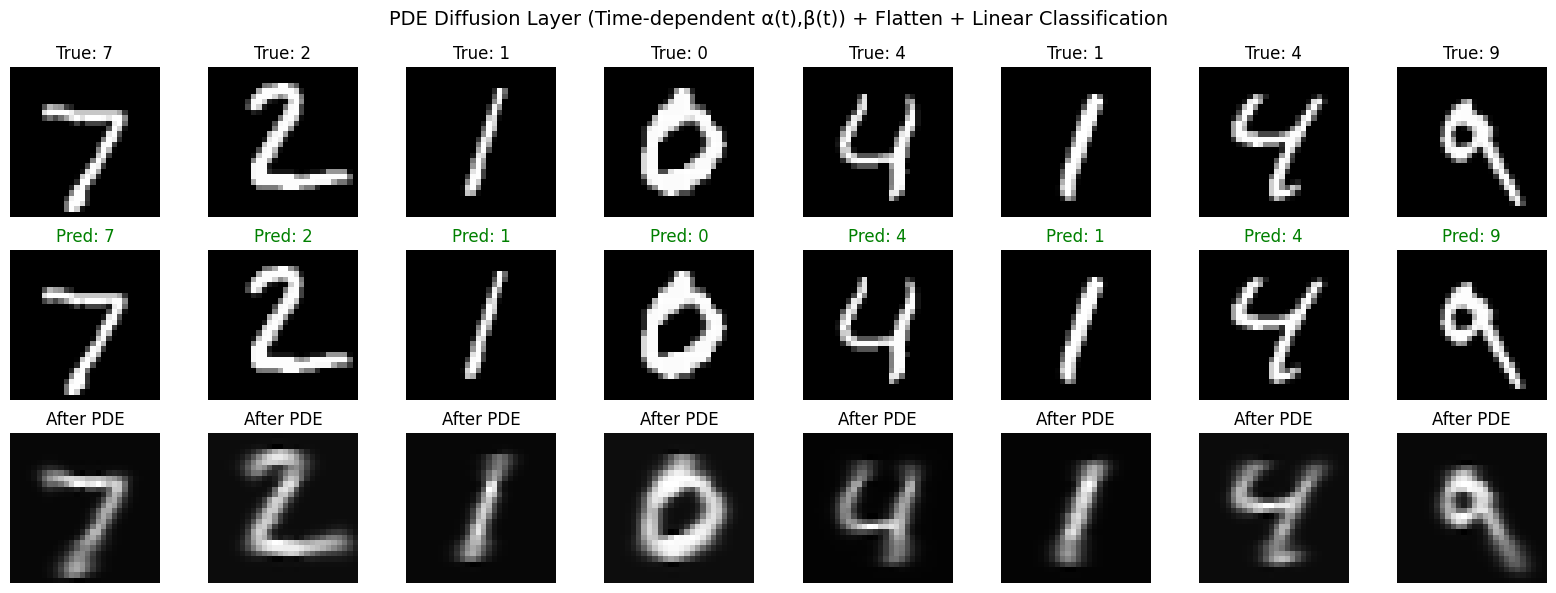

In [ ]:
# alpha and beta are time dependent vectors. Test Accuracy: 97.62%
# T = 0.01, dt = 0.005 and steps = 2. Two dense layers with RELU and 5 epochs.

# T = 1 , dt = 0.1 and steps = 10.Two dense layers with RELU and 5 epochs.Test Accuracy : 97.04%.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

#Optimized PDE Diffusion Layer
class DiffusionLayer(nn.Module):
    def __init__(self, size=28, dt=0.1, dx=1.0, num_steps=10):
        super().__init__()
        self.size = size
        self.dt = dt
        self.dx = dx
        self.num_steps = num_steps

        # Base diffusion coefficients (learnable)
        self.alpha_base = nn.Parameter(torch.ones(size) * 2.0)  # Base coefficients for rows
        self.beta_base = nn.Parameter(torch.ones(size) * 2.0)   # Base coefficients for columns

        # Time-dependent modulation parameters (learnable)
        self.alpha_time_coeff = nn.Parameter(torch.zeros(size))  # Time modulation for alpha
        self.beta_time_coeff = nn.Parameter(torch.zeros(size))   # Time modulation for beta

    def get_alpha_beta_at_time(self, t):
        """Get alpha and beta coefficients at time t"""
        # Alpha and beta change with time: base + time_coeff * t
        alpha_t = self.alpha_base + self.alpha_time_coeff * t
        beta_t = self.beta_base + self.beta_time_coeff * t
        return alpha_t, beta_t

    def forward(self, u):
        B, _, H, W = u.shape
        u = u.squeeze(1)

        # Apply multiple diffusion steps with time-dependent coefficients
        current_time = 0.0
        for step in range(self.num_steps):
            # Get alpha and beta at current time
            alpha_t, beta_t = self.get_alpha_beta_at_time(current_time)

            # Strang splitting: half step x, full step y, half step x
            u = self.diffuse_x_vectorized(u, alpha_t, self.dt / 2, self.dx)
            current_time += self.dt / 2

            alpha_t, beta_t = self.get_alpha_beta_at_time(current_time)
            u = self.diffuse_y_vectorized(u, beta_t, self.dt, self.dx)
            current_time += self.dt / 2

            alpha_t, beta_t = self.get_alpha_beta_at_time(current_time)
            u = self.diffuse_x_vectorized(u, alpha_t, self.dt / 2, self.dx)
            current_time += self.dt / 2

        return u.unsqueeze(1)

    def diffuse_x_vectorized(self, u, alpha, dt, dx):
        """Vectorized diffusion in x-direction using batch Thomas solver"""
        B, H, W = u.shape

        # Compute coefficients for all rows simultaneously
        a = -alpha * dt / dx**2  # Shape: (H,) - alpha is already scaled by dt
        b = 1 + 2 * alpha * dt / dx**2  # Shape: (H,)
        c = a  # Shape: (H,)

        # Process each row: u is (B, H, W), we want to solve along W dimension for each H
        # Reshape: (B, H, W) -> (B*H, W) to process all batch*row combinations
        u_reshaped = u.view(B * H, W)  # (B*H, W)

        # Expand coefficients for all batch*row combinations
        a_expanded = a.repeat(B)  # (B*H,) - repeat for each batch
        b_expanded = b.repeat(B)  # (B*H,)
        c_expanded = c.repeat(B)  # (B*H,)

        # Solve all systems simultaneously
        result = self.thomas_solver_vectorized(a_expanded, b_expanded, c_expanded, u_reshaped)

        # Reshape back to (B, H, W)
        return result.view(B, H, W)

    def diffuse_y_vectorized(self, u, beta, dt, dx):
        """Vectorized diffusion in y-direction using batch Thomas solver"""
        B, H, W = u.shape

        # Compute coefficients for all columns simultaneously
        a = -beta * dt / dx**2  # Shape: (W,) - beta is already scaled by dt
        b = 1 + 2 * beta * dt / dx**2  # Shape: (W,)
        c = a  # Shape: (W,)

        # Process each column: u is (B, H, W), we want to solve along H dimension for each W
        # Reshape: (B, H, W) -> (B*W, H) to process all batch*column combinations
        u_reshaped = u.transpose(1, 2).contiguous().view(B * W, H)  # (B*W, H)

        # Expand coefficients for all batch*column combinations
        a_expanded = a.repeat(B)  # (B*W,) - repeat for each batch
        b_expanded = b.repeat(B)  # (B*W,)
        c_expanded = c.repeat(B)  # (B*W,)

        # Solve all systems simultaneously
        result = self.thomas_solver_vectorized(a_expanded, b_expanded, c_expanded, u_reshaped)

        # Reshape back to (B, H, W)
        return result.view(B, W, H).transpose(1, 2).contiguous()

    def thomas_solver_vectorized(self, a, b, c, d):
        """
        Vectorized Thomas algorithm for tridiagonal systems - gradient safe
        a, b, c: coefficients (shape: B,)
        d: right-hand side (shape: B, N)
        Returns: solution x (shape: B, N)
        """
        B, N = d.shape
        device = d.device

        # Expand scalar coefficients to match dimensions
        a = a.unsqueeze(1).expand(-1, N)  # (B, N)
        b = b.unsqueeze(1).expand(-1, N)  # (B, N)
        c = c.unsqueeze(1).expand(-1, N)  # (B, N)

        # Initialize arrays
        c_star = torch.zeros_like(d)
        d_star = torch.zeros_like(d)

        # Forward elimination - avoid in-place operations
        c_star_list = []
        d_star_list = []

        # First column
        c_star_0 = c[:, 0] / b[:, 0]
        d_star_0 = d[:, 0] / b[:, 0]
        c_star_list.append(c_star_0)
        d_star_list.append(d_star_0)

        # Forward sweep
        for i in range(1, N):
            denom = b[:, i] - a[:, i] * c_star_list[i-1]
            c_star_i = c[:, i] / denom
            d_star_i = (d[:, i] - a[:, i] * d_star_list[i-1]) / denom
            c_star_list.append(c_star_i)
            d_star_list.append(d_star_i)

        # Stack results
        c_star = torch.stack(c_star_list, dim=1)
        d_star = torch.stack(d_star_list, dim=1)

        # Back substitution - avoid in-place operations
        x_list = [None] * N
        x_list[-1] = d_star[:, -1]

        # Backward sweep
        for i in range(N-2, -1, -1):
            x_list[i] = d_star[:, i] - c_star[:, i] * x_list[i+1]

        # Stack results
        x = torch.stack(x_list, dim=1)

        return x


#Enhanced Neural Network
class PDEClassifier(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super().__init__()
        self.diff = DiffusionLayer()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.diff(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

#Training Setup
transform = transforms.Compose([transforms.ToTensor()])
train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)
test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transform),
    batch_size=128, shuffle=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = PDEClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#Training Loop
print("Starting training...")
import time

for epoch in range(5):
    start_time = time.time()
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

    epoch_time = time.time() - start_time
    avg_loss = total_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Monitor time-dependent parameters
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Time: {epoch_time:.2f}s")

    # Show parameters at different time points
    with torch.no_grad():
        alpha_t0, beta_t0 = model.diff.get_alpha_beta_at_time(0.0)
        alpha_t1, beta_t1 = model.diff.get_alpha_beta_at_time(1.0)
        alpha_t2, beta_t2 = model.diff.get_alpha_beta_at_time(2.0)

        print(f"Alpha_base stats - Mean: {model.diff.alpha_base.mean().item():.4f}, Range: [{model.diff.alpha_base.min().item():.4f}, {model.diff.alpha_base.max().item():.4f}]")
        print(f"Alpha_time_coeff stats - Mean: {model.diff.alpha_time_coeff.mean().item():.4f}, Range: [{model.diff.alpha_time_coeff.min().item():.4f}, {model.diff.alpha_time_coeff.max().item():.4f}]")
        print(f"Alpha at t=0: Mean={alpha_t0.mean().item():.4f}, at t=1: Mean={alpha_t1.mean().item():.4f}, at t=2: Mean={alpha_t2.mean().item():.4f}")

        print(f"Beta_base stats - Mean: {model.diff.beta_base.mean().item():.4f}, Range: [{model.diff.beta_base.min().item():.4f}, {model.diff.beta_base.max().item():.4f}]")
        print(f"Beta_time_coeff stats - Mean: {model.diff.beta_time_coeff.mean().item():.4f}, Range: [{model.diff.beta_time_coeff.min().item():.4f}, {model.diff.beta_time_coeff.max().item():.4f}]")
        print(f"Beta at t=0: Mean={beta_t0.mean().item():.4f}, at t=1: Mean={beta_t1.mean().item():.4f}, at t=2: Mean={beta_t2.mean().item():.4f}")

    print("-" * 80)

print("Training completed!")

#Evaluation & Visualization
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.argmax(dim=1)
        test_correct += pred.eq(labels).sum().item()
        test_total += labels.size(0)

test_acc = 100. * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")

#Visualization
with torch.no_grad():
    images, labels = next(iter(test_loader))
    images = images.to(device)
    outputs = model(images)
    predicted = outputs.argmax(dim=1)

    # Show learned time-dependent parameters
    print(f"\nLearned Time-Dependent Parameters:")
    print(f"dt (time step): {model.diff.dt}")
    print(f"num_steps: {model.diff.num_steps}")

    with torch.no_grad():
        print(f"\nBase Parameters:")
        print(f"Alpha_base (shape: {model.diff.alpha_base.shape}): {model.diff.alpha_base.detach().cpu().numpy()}")
        print(f"Beta_base (shape: {model.diff.beta_base.shape}): {model.diff.beta_base.detach().cpu().numpy()}")

        print(f"\nTime Modulation Parameters:")
        print(f"Alpha_time_coeff: {model.diff.alpha_time_coeff.detach().cpu().numpy()}")
        print(f"Beta_time_coeff: {model.diff.beta_time_coeff.detach().cpu().numpy()}")

        print(f"\nDiffusion coefficients at different times:")
        for t in [0.0, 0.5, 1.0, 1.5]:
            alpha_t, beta_t = model.diff.get_alpha_beta_at_time(t)
            print(f"t={t}: Alpha_mean={alpha_t.mean().item():.4f}, Beta_mean={beta_t.mean().item():.4f}")

    print(f"\nHow time-dependence works:")
    print(f"- Alpha(t) = Alpha_base + Alpha_time_coeff * t")
    print(f"- Beta(t) = Beta_base + Beta_time_coeff * t")
    print(f"- At each diffusion step, coefficients are updated based on current time")
    print(f"- Total simulation time: {model.diff.num_steps * model.diff.dt}")
    print(f"- This allows diffusion properties to evolve during the process")

    # Plot results
    images_cpu = images.cpu().numpy()
    preds_cpu = predicted.cpu().numpy()
    labels_cpu = labels.numpy()

    plt.figure(figsize=(16, 6))
    for i in range(8):
        # Original images
        plt.subplot(3, 8, i + 1)
        plt.imshow(images_cpu[i, 0], cmap='gray')
        plt.axis('off')
        plt.title(f"True: {labels_cpu[i]}")

        # Predictions
        plt.subplot(3, 8, i + 9)
        plt.imshow(images_cpu[i, 0], cmap='gray')
        plt.axis('off')
        color = 'green' if preds_cpu[i] == labels_cpu[i] else 'red'
        plt.title(f"Pred: {preds_cpu[i]}", color=color)

        # Diffused images
        plt.subplot(3, 8, i + 17)
        diffused = model.diff(images[i:i+1]).squeeze().cpu().numpy()
        plt.imshow(diffused, cmap='gray')
        plt.axis('off')
        plt.title("After PDE")

    plt.suptitle('PDE Diffusion Layer (Time-dependent α(t),β(t)) + Flatten + Linear Classification', fontsize=14)
    plt.tight_layout()
    plt.show()

Starting fixed PDE diffusion training...
Using device: cpu
Starting fixed training...
Epoch 1, Batch 0, Loss: 2.3068, Acc: 10.16%
Epoch 1, Batch 100, Loss: 1.0800, Acc: 67.57%
Epoch 1, Batch 200, Loss: 0.9654, Acc: 74.60%
Epoch 1, Batch 300, Loss: 0.9013, Acc: 77.82%
Epoch 1, Batch 400, Loss: 0.8945, Acc: 80.06%
Epoch 1 - Loss: 1.0554, Train Acc: 81.14%, Time: 1340.57s
Alpha - Base: μ=1.991, σ=0.117 | Time: μ=-0.017, σ=0.121
Beta - Base: μ=1.926, σ=0.127 | Time: μ=-0.089, σ=0.131
--------------------------------------------------------------------------------
Epoch 2, Batch 0, Loss: 0.9233, Acc: 84.38%
Epoch 2, Batch 100, Loss: 0.8010, Acc: 88.54%
Epoch 2, Batch 200, Loss: 0.8798, Acc: 89.27%
Epoch 2, Batch 300, Loss: 0.7822, Acc: 89.72%
Epoch 2, Batch 400, Loss: 0.8196, Acc: 90.07%
Epoch 2 - Loss: 0.8215, Train Acc: 90.25%, Time: 1356.51s
Alpha - Base: μ=1.985, σ=0.161 | Time: μ=-0.027, σ=0.167
Beta - Base: μ=1.893, σ=0.178 | Time: μ=-0.132, σ=0.185
-----------------------------------

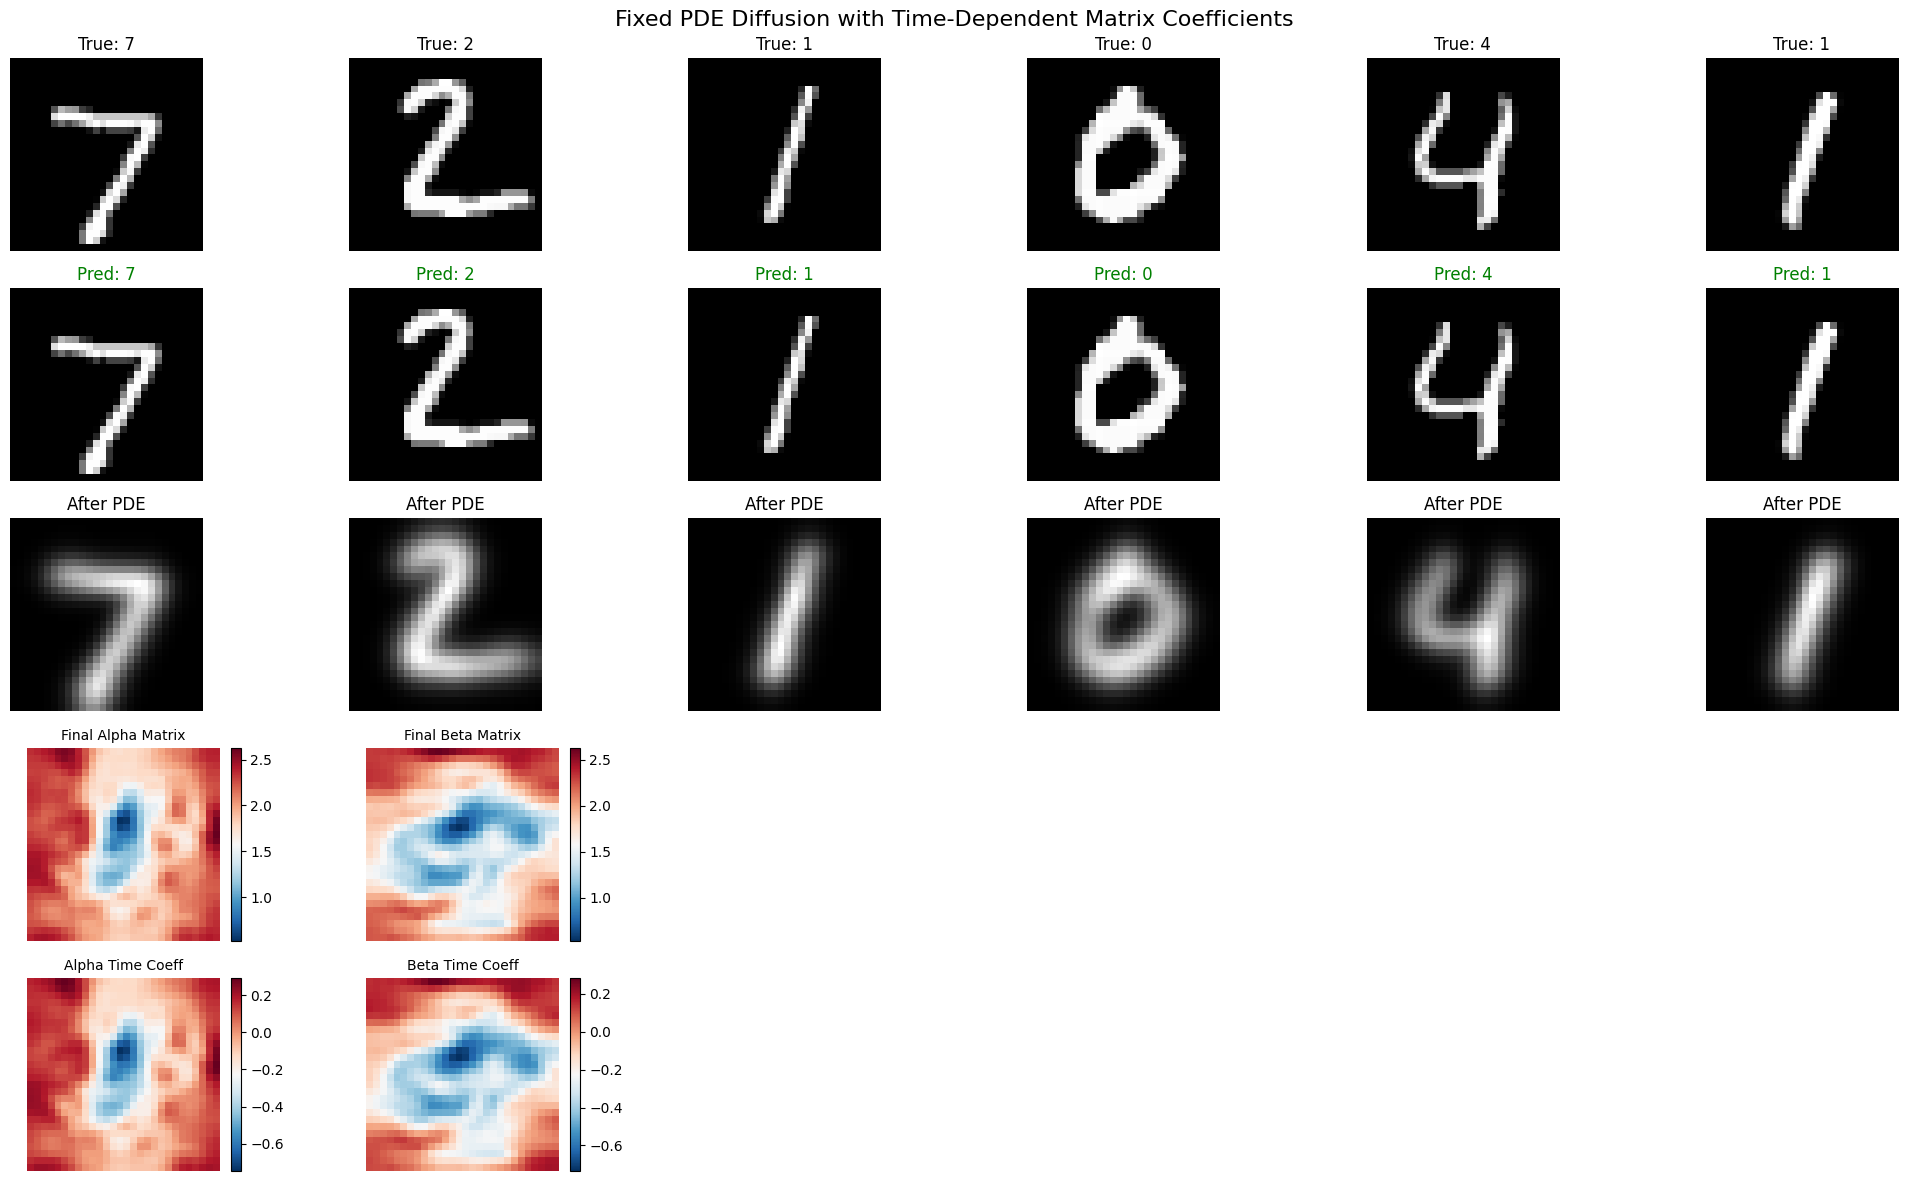

In [ ]:
# alpha and beta matrices dependent on time. Test Accuracy: 97.46%
#All parameters are same as before. T = 0.01, dt = 0.005 num_steps = 2

#Test Accuracy: 95.47%
#Simulation parameters: dt=0.1, steps=10, T = 1

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

#Fixed PDE Diffusion Layer with Matrix Parameters
class DiffusionLayer(nn.Module):
    def __init__(self, size=28, dt=0.1, dx=1.0, num_steps=10):
        super().__init__()
        self.size = size
        self.dt = dt
        self.dx = dx
        self.num_steps = num_steps

        # Base diffusion coefficients as matrices (learnable)
        self.alpha_base = nn.Parameter(torch.ones(size, size) * 2.0)
        self.beta_base = nn.Parameter(torch.ones(size, size) * 2.0)

        # Time-dependent modulation parameters as matrices (learnable)
        self.alpha_time_coeff = nn.Parameter(torch.zeros(size, size))
        self.beta_time_coeff = nn.Parameter(torch.zeros(size, size))

        # Stability parameters
        self.stability_eps = 1e-6

    def get_alpha_beta_at_time(self, t):
        """Get alpha and beta coefficient matrices at time t"""
        alpha_t = self.alpha_base + self.alpha_time_coeff * t
        beta_t = self.beta_base + self.beta_time_coeff * t

        # Ensure positive coefficients for stability
        alpha_t = torch.clamp(alpha_t, min=self.stability_eps)
        beta_t = torch.clamp(beta_t, min=self.stability_eps)

        return alpha_t, beta_t

    def forward(self, u):
        B, _, H, W = u.shape
        u = u.squeeze(1)

        # Apply multiple diffusion steps with time-dependent coefficients
        current_time = 0.0
        for step in range(self.num_steps):
            # Get alpha and beta matrices at current time
            alpha_t, beta_t = self.get_alpha_beta_at_time(current_time)

            # Strang splitting: half step x, full step y, half step x
            u = self.diffuse_x_vectorized(u, alpha_t, self.dt / 2, self.dx)
            current_time += self.dt / 2

            alpha_t, beta_t = self.get_alpha_beta_at_time(current_time)
            u = self.diffuse_y_vectorized(u, beta_t, self.dt, self.dx)
            current_time += self.dt / 2

            alpha_t, beta_t = self.get_alpha_beta_at_time(current_time)
            u = self.diffuse_x_vectorized(u, alpha_t, self.dt / 2, self.dx)

        return u.unsqueeze(1)

    def diffuse_x_vectorized(self, u, alpha_matrix, dt, dx):
        """Fixed vectorized diffusion in x-direction - no in-place ops"""
        B, H, W = u.shape
        device = u.device

        # Reshape for batch processing: (B, H, W) -> (B*H, W)
        u_flat = u.contiguous().view(B * H, W)

        # Expand alpha_matrix for all batches: (H, W) -> (B*H, W)
        alpha_expanded = alpha_matrix.unsqueeze(0).expand(B, -1, -1).contiguous().view(B * H, W)

        # Apply smoothing to coefficients for stability
        alpha_smooth = self.smooth_coefficients(alpha_expanded, dim=1)
        coeff = alpha_smooth * dt / (dx ** 2)

        # Build tridiagonal system coefficients
        a = -coeff  # sub-diagonal
        c = -coeff  # super-diagonal
        b = 1 + 2 * coeff  # main diagonal

        # Apply boundary conditions (Neumann - no flux at boundaries)
        b_modified = b.clone()  # No in-place modification
        b_modified[:, 0] = 1 + coeff[:, 0]
        b_modified[:, -1] = 1 + coeff[:, -1]

        # Solve all tridiagonal systems in parallel
        result = self.thomas_solver_batch(a, b_modified, c, u_flat)

        return result.view(B, H, W)

    def diffuse_y_vectorized(self, u, beta_matrix, dt, dx):
        """Fixed vectorized diffusion in y-direction - no in-place ops"""
        B, H, W = u.shape
        device = u.device

        # Transpose to work on columns: (B, H, W) -> (B, W, H)
        u_t = u.transpose(1, 2).contiguous()
        u_flat = u_t.view(B * W, H)

        # Expand beta_matrix for all batches: (H, W) -> (B*W, H)
        beta_expanded = beta_matrix.t().unsqueeze(0).expand(B, -1, -1).contiguous().view(B * W, H)

        # Apply smoothing to coefficients for stability
        beta_smooth = self.smooth_coefficients(beta_expanded, dim=1)
        coeff = beta_smooth * dt / (dx ** 2)

        # Build tridiagonal system coefficients
        a = -coeff  # sub-diagonal
        c = -coeff  # super-diagonal
        b = 1 + 2 * coeff  # main diagonal

        # Apply boundary conditions (Neumann - no flux at boundaries)
        b_modified = b.clone()  # No in-place modification
        b_modified[:, 0] = 1 + coeff[:, 0]
        b_modified[:, -1] = 1 + coeff[:, -1]

        # Solve all tridiagonal systems in parallel
        result = self.thomas_solver_batch(a, b_modified, c, u_flat)

        # Transpose back: (B*W, H) -> (B, W, H) -> (B, H, W)
        return result.view(B, W, H).transpose(1, 2).contiguous()

    def smooth_coefficients(self, coeffs, dim=1, kernel_size=3):
        """Apply smoothing to coefficients for numerical stability"""
        if kernel_size == 1:
            return coeffs

        # Simple moving average smoothing using conv1d
        padding = kernel_size // 2
        if dim == 1:
            coeffs_padded = F.pad(coeffs, (padding, padding), mode='replicate')
            kernel = torch.ones(1, 1, kernel_size, device=coeffs.device) / kernel_size
            smoothed = F.conv1d(coeffs_padded.unsqueeze(1), kernel, padding=0).squeeze(1)
        else:
            raise NotImplementedError("Only dim=1 smoothing implemented")

        return smoothed

    def thomas_solver_batch(self, a, b, c, d):
        """
        Fixed batch Thomas algorithm - no in-place operations
        All inputs have shape (batch_size, N)
        """
        batch_size, N = d.shape
        device = d.device
        eps = self.stability_eps

        # Initialize working arrays - avoid in-place operations
        c_star = torch.zeros_like(d)
        d_star = torch.zeros_like(d)

        # Forward elimination with numerical stability
        c_star = c_star.clone()
        d_star = d_star.clone()

        # First step
        denom_0 = b[:, 0] + eps
        c_star = c_star.scatter(1, torch.zeros(batch_size, 1, dtype=torch.long, device=device),
                               (c[:, 0] / denom_0).unsqueeze(1))
        d_star = d_star.scatter(1, torch.zeros(batch_size, 1, dtype=torch.long, device=device),
                               (d[:, 0] / denom_0).unsqueeze(1))

        # Forward sweep - avoiding in-place operations
        for i in range(1, N):
            denom = b[:, i] - a[:, i] * c_star[:, i-1] + eps

            if i < N-1:
                c_star = c_star.scatter(1, torch.full((batch_size, 1), i, dtype=torch.long, device=device),
                                       (c[:, i] / denom).unsqueeze(1))

            d_val = (d[:, i] - a[:, i] * d_star[:, i-1]) / denom
            d_star = d_star.scatter(1, torch.full((batch_size, 1), i, dtype=torch.long, device=device),
                                   d_val.unsqueeze(1))

        # Back substitution - avoiding in-place operations
        x = torch.zeros_like(d)
        x = x.scatter(1, torch.full((batch_size, 1), N-1, dtype=torch.long, device=device),
                     d_star[:, -1].unsqueeze(1))

        # Backward sweep
        for i in range(N-2, -1, -1):
            x_val = d_star[:, i] - c_star[:, i] * x[:, i+1]
            x = x.scatter(1, torch.full((batch_size, 1), i, dtype=torch.long, device=device),
                         x_val.unsqueeze(1))

        return x


#Enhanced Neural Network
class PDEClassifier(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super().__init__()
        self.diff = DiffusionLayer()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.diff(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


#Training Setup
def create_data_loaders(batch_size=128):  # Reduced batch size for stability
    """Create optimized data loaders with data augmentation"""
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(5),
        transforms.RandomAffine(0, translate=(0.05, 0.05))
    ])

    transform_test = transforms.Compose([transforms.ToTensor()])

    train_loader = DataLoader(
        datasets.MNIST('./data', train=True, download=True, transform=transform_train),
        batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )
    test_loader = DataLoader(
        datasets.MNIST('./data', train=False, transform=transform_test),
        batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
    )

    return train_loader, test_loader


def train_model():
    """Fixed training function"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create data loaders
    train_loader, test_loader = create_data_loaders(batch_size=128)

    # Initialize model
    model = PDEClassifier().to(device)

    # Conservative optimizer settings for stability
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Training loop
    print("Starting fixed training...")
    import time

    for epoch in range(5):
        start_time = time.time()
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            # Use regular training (avoid mixed precision for now)
            output = model(imgs)
            loss = criterion(output, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

        scheduler.step()
        epoch_time = time.time() - start_time
        avg_loss = total_loss / len(train_loader)
        train_acc = 100. * correct / total

        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Time: {epoch_time:.2f}s")

        # Monitor parameters
        with torch.no_grad():
            alpha_stats = {
                'base_mean': model.diff.alpha_base.mean().item(),
                'base_std': model.diff.alpha_base.std().item(),
                'time_mean': model.diff.alpha_time_coeff.mean().item(),
                'time_std': model.diff.alpha_time_coeff.std().item()
            }
            beta_stats = {
                'base_mean': model.diff.beta_base.mean().item(),
                'base_std': model.diff.beta_base.std().item(),
                'time_mean': model.diff.beta_time_coeff.mean().item(),
                'time_std': model.diff.beta_time_coeff.std().item()
            }

            print(f"Alpha - Base: μ={alpha_stats['base_mean']:.3f}, σ={alpha_stats['base_std']:.3f} | "
                  f"Time: μ={alpha_stats['time_mean']:.3f}, σ={alpha_stats['time_std']:.3f}")
            print(f"Beta - Base: μ={beta_stats['base_mean']:.3f}, σ={beta_stats['base_std']:.3f} | "
                  f"Time: μ={beta_stats['time_mean']:.3f}, σ={beta_stats['time_std']:.3f}")

        print("-" * 80)

    return model, test_loader


def evaluate_and_visualize(model, test_loader):
    """Evaluation and visualization"""
    device = next(model.parameters()).device
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            output = model(imgs)
            pred = output.argmax(dim=1)
            test_correct += pred.eq(labels).sum().item()
            test_total += labels.size(0)

    test_acc = 100. * test_correct / test_total
    print(f"Test Accuracy: {test_acc:.2f}%")

    # Visualization
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images = images.to(device)
        outputs = model(images)
        predicted = outputs.argmax(dim=1)

        # Parameter analysis
        print(f"\nMatrix Parameter Analysis:")
        print(f"Simulation parameters: dt={model.diff.dt}, steps={model.diff.num_steps}")

        # Time evolution analysis
        time_points = torch.linspace(0, model.diff.num_steps * model.diff.dt, 5)
        print(f"\nTime Evolution of Diffusion Coefficients:")
        for t in time_points:
            alpha_t, beta_t = model.diff.get_alpha_beta_at_time(t.item())
            print(f"t={t.item():.2f}: α(μ±σ)={alpha_t.mean().item():.3f}±{alpha_t.std().item():.3f}, "
                  f"β(μ±σ)={beta_t.mean().item():.3f}±{beta_t.std().item():.3f}")

        # Spatial analysis
        alpha_final, beta_final = model.diff.get_alpha_beta_at_time(model.diff.num_steps * model.diff.dt)
        print(f"\nSpatial Variation Analysis:")
        print(f"Alpha matrix - Range: [{alpha_final.min().item():.3f}, {alpha_final.max().item():.3f}]")
        print(f"Beta matrix - Range: [{beta_final.min().item():.3f}, {beta_final.max().item():.3f}]")

        # Visualization
        plt.figure(figsize=(20, 12))

        # Sample images and predictions
        for i in range(6):
            # Original
            plt.subplot(5, 6, i + 1)
            plt.imshow(images[i, 0].cpu().numpy(), cmap='gray')
            plt.axis('off')
            plt.title(f"True: {labels[i]}")

            # Prediction
            plt.subplot(5, 6, i + 7)
            plt.imshow(images[i, 0].cpu().numpy(), cmap='gray')
            plt.axis('off')
            color = 'green' if predicted[i] == labels[i] else 'red'
            plt.title(f"Pred: {predicted[i]}", color=color)

            # Diffused
            plt.subplot(5, 6, i + 13)
            diffused = model.diff(images[i:i+1]).squeeze().cpu().numpy()
            plt.imshow(diffused, cmap='gray')
            plt.axis('off')
            plt.title("After PDE")

        # Parameter matrices visualization
        matrices = [
            (alpha_final.cpu().numpy(), "Final Alpha Matrix", 19),
            (beta_final.cpu().numpy(), "Final Beta Matrix", 20),
            (model.diff.alpha_time_coeff.detach().cpu().numpy(), "Alpha Time Coeff", 25),
            (model.diff.beta_time_coeff.detach().cpu().numpy(), "Beta Time Coeff", 26)
        ]

        for matrix, title, pos in matrices:
            plt.subplot(5, 6, pos)
            im = plt.imshow(matrix, cmap='RdBu_r')
            plt.colorbar(im, fraction=0.046, pad=0.04)
            plt.title(title, fontsize=10)
            plt.axis('off')

        plt.suptitle('Fixed PDE Diffusion with Time-Dependent Matrix Coefficients', fontsize=16)
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    print("Starting fixed PDE diffusion training...")
    model, test_loader = train_model()
    print("\nTraining completed! Evaluating...")
    evaluate_and_visualize(model, test_loader)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.10MB/s]


Using device: cuda
Starting training...
Epoch 1, Batch 0, Loss: 2.3030, Acc: 15.62%
Epoch 1, Batch 100, Loss: 1.6450, Acc: 70.78%
Epoch 1, Batch 200, Loss: 1.5645, Acc: 79.95%
Epoch 1, Batch 300, Loss: 1.5635, Acc: 83.33%
Epoch 1, Batch 400, Loss: 1.5594, Acc: 85.22%
Epoch 1 - Loss: 1.6310, Train Acc: 86.09%, Time: 779.55s
Alpha (horizontal diffusion): 1.7401
Beta (vertical diffusion): 2.6579
--------------------------------------------------------------------------------
Training completed!
Test Accuracy: 92.50%

Learned Parameters:
Alpha (horizontal diffusion coefficient): 1.7401
Beta (vertical diffusion coefficient): 2.6579

What alpha and beta represent:
- Alpha: controls horizontal diffusion (same for all rows)
- Beta: controls vertical diffusion (same for all columns)
- Higher values = more diffusion/blurring in that direction
- Values around 1.0 are moderate, <0.5 is low diffusion, >2.0 is high diffusion


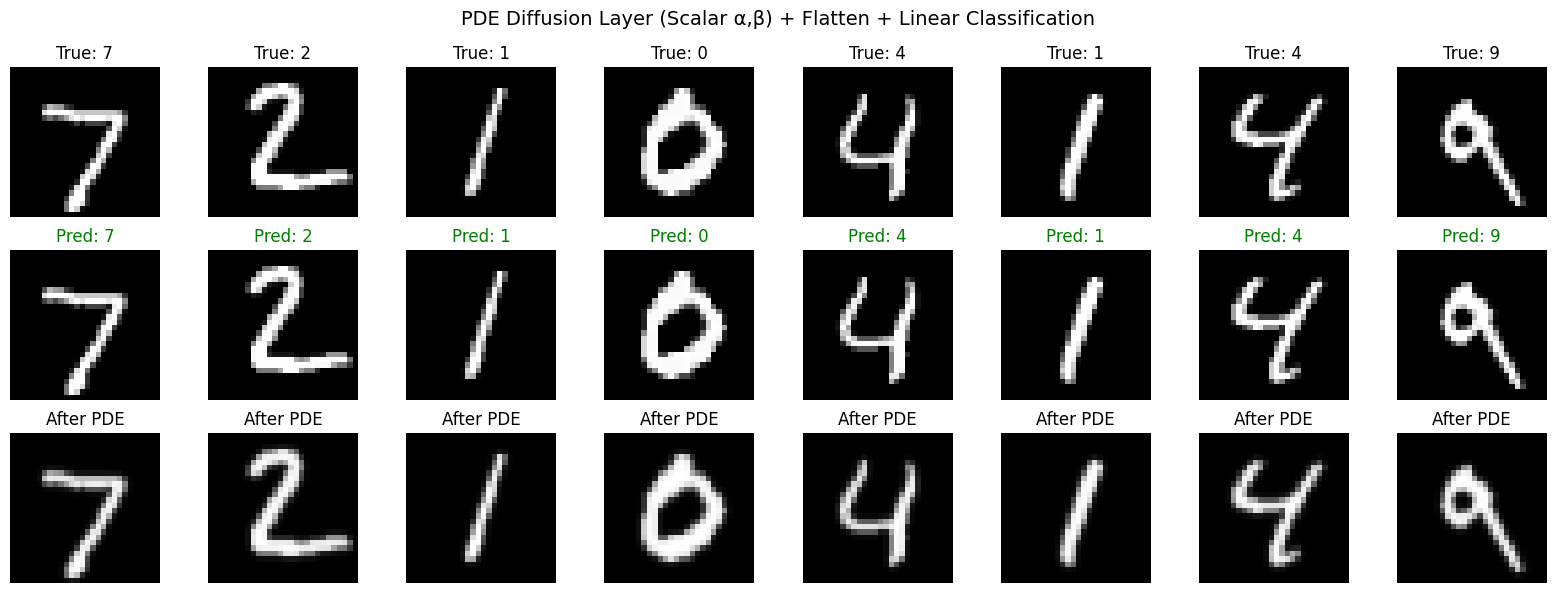

In [1]:
# alpha and beta are scalars. everything the same just use softmax function on the second dense layer.
#No improvement

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Optimized PDE Diffusion Layer
class DiffusionLayer(nn.Module):
    def __init__(self, size=28, dt=0.002, dx=1.0, num_steps=20):  # Increased dt and added multiple steps
        super().__init__()
        self.size = size
        self.dt = dt
        self.dx = dx
        self.num_steps = num_steps  # Multiple diffusion steps

        # Initialize as scalar parameters instead of vectors
        self.alpha = nn.Parameter(torch.tensor(2.0))  # Single scalar value
        self.beta = nn.Parameter(torch.tensor(3.0))   # Single scalar value

    def forward(self, u):
        B, _, H, W = u.shape
        u = u.squeeze(1)

        # Apply multiple diffusion steps for more visible effect
        for step in range(self.num_steps):
            # Strang splitting: half step x, full step y, half step x
            u = self.diffuse_x_vectorized(u, self.alpha, self.dt / 2, self.dx)
            u = self.diffuse_y_vectorized(u, self.beta, self.dt, self.dx)
            u = self.diffuse_x_vectorized(u, self.alpha, self.dt / 2, self.dx)

        return u.unsqueeze(1)

    def diffuse_x_vectorized(self, u, alpha, dt, dx):
        """Vectorized diffusion in x-direction using batch Thomas solver"""
        B, H, W = u.shape

        # Compute coefficients - now alpha is a scalar, same for all rows
        a = -alpha * dt / dx**2  # Scalar
        b = 1 + 2 * alpha * dt / dx**2  # Scalar
        c = a  # Scalar

        # Process each row: u is (B, H, W), we want to solve along W dimension for each H
        # Reshape: (B, H, W) -> (B*H, W) to process all batch*row combinations
        u_reshaped = u.view(B * H, W)  # (B*H, W)

        # Expand scalar coefficients for all batch*row combinations
        a_expanded = a.expand(B * H)  # (B*H,) - same value for all
        b_expanded = b.expand(B * H)  # (B*H,)
        c_expanded = c.expand(B * H)  # (B*H,)

        # Solve all systems simultaneously
        result = self.thomas_solver_vectorized(a_expanded, b_expanded, c_expanded, u_reshaped)

        # Reshape back to (B, H, W)
        return result.view(B, H, W)

    def diffuse_y_vectorized(self, u, beta, dt, dx):
        """Vectorized diffusion in y-direction using batch Thomas solver"""
        B, H, W = u.shape

        # Compute coefficients - now beta is a scalar, same for all columns
        a = -beta * dt / dx**2  # Scalar
        b = 1 + 2 * beta * dt / dx**2  # Scalar
        c = a  # Scalar

        # Process each column: u is (B, H, W), we want to solve along H dimension for each W
        # Reshape: (B, H, W) -> (B*W, H) to process all batch*column combinations
        u_reshaped = u.transpose(1, 2).contiguous().view(B * W, H)  # (B*W, H)

        # Expand scalar coefficients for all batch*column combinations
        a_expanded = a.expand(B * W)  # (B*W,) - same value for all
        b_expanded = b.expand(B * W)  # (B*W,)
        c_expanded = c.expand(B * W)  # (B*W,)

        # Solve all systems simultaneously
        result = self.thomas_solver_vectorized(a_expanded, b_expanded, c_expanded, u_reshaped)

        # Reshape back to (B, H, W)
        return result.view(B, W, H).transpose(1, 2).contiguous()

    def thomas_solver_vectorized(self, a, b, c, d):
        """
        Vectorized Thomas algorithm for tridiagonal systems - gradient safe
        a, b, c: coefficients (shape: B,)
        d: right-hand side (shape: B, N)
        Returns: solution x (shape: B, N)
        """
        B, N = d.shape
        device = d.device

        # Expand scalar coefficients to match dimensions
        a = a.unsqueeze(1).expand(-1, N)  # (B, N)
        b = b.unsqueeze(1).expand(-1, N)  # (B, N)
        c = c.unsqueeze(1).expand(-1, N)  # (B, N)

        # Initialize arrays
        c_star = torch.zeros_like(d)
        d_star = torch.zeros_like(d)

        # Forward elimination - avoid in-place operations
        c_star_list = []
        d_star_list = []

        # First column
        c_star_0 = c[:, 0] / b[:, 0]
        d_star_0 = d[:, 0] / b[:, 0]
        c_star_list.append(c_star_0)
        d_star_list.append(d_star_0)

        # Forward sweep
        for i in range(1, N):
            denom = b[:, i] - a[:, i] * c_star_list[i-1]
            c_star_i = c[:, i] / denom
            d_star_i = (d[:, i] - a[:, i] * d_star_list[i-1]) / denom
            c_star_list.append(c_star_i)
            d_star_list.append(d_star_i)

        # Stack results
        c_star = torch.stack(c_star_list, dim=1)
        d_star = torch.stack(d_star_list, dim=1)

        # Back substitution - avoid in-place operations
        x_list = [None] * N
        x_list[-1] = d_star[:, -1]

        # Backward sweep
        for i in range(N-2, -1, -1):
            x_list[i] = d_star[:, i] - c_star[:, i] * x_list[i+1]

        # Stack results
        x = torch.stack(x_list, dim=1)

        return x

#Enhanced Neural Network
class PDEClassifier(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super().__init__()
        self.diff = DiffusionLayer()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.diff(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return F.softmax(self.fc2(x), dim=1)
#Training Setup
transform = transforms.Compose([transforms.ToTensor()])
train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)
test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transform),
    batch_size=128, shuffle=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = PDEClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#Training Loop
print("Starting training...")
import time

for epoch in range(1):
    start_time = time.time()
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

    epoch_time = time.time() - start_time
    avg_loss = total_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Monitor alpha and beta parameters (now scalars)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Time: {epoch_time:.2f}s")
    print(f"Alpha (horizontal diffusion): {model.diff.alpha.item():.4f}")
    print(f"Beta (vertical diffusion): {model.diff.beta.item():.4f}")
    print("-" * 80)

print("Training completed!")

#Evaluation & Visualization
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.argmax(dim=1)
        test_correct += pred.eq(labels).sum().item()
        test_total += labels.size(0)

test_acc = 100. * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")

#Visualization
with torch.no_grad():
    images, labels = next(iter(test_loader))
    images = images.to(device)
    outputs = model(images)
    predicted = outputs.argmax(dim=1)

    # Show learned parameters
    print(f"\nLearned Parameters:")
    print(f"Alpha (horizontal diffusion coefficient): {model.diff.alpha.item():.4f}")
    print(f"Beta (vertical diffusion coefficient): {model.diff.beta.item():.4f}")
    print(f"\nWhat alpha and beta represent:")
    print(f"- Alpha: controls horizontal diffusion (same for all rows)")
    print(f"- Beta: controls vertical diffusion (same for all columns)")
    print(f"- Higher values = more diffusion/blurring in that direction")
    print(f"- Values around 1.0 are moderate, <0.5 is low diffusion, >2.0 is high diffusion")

    # Plot results
    images_cpu = images.cpu().numpy()
    preds_cpu = predicted.cpu().numpy()
    labels_cpu = labels.numpy()

    plt.figure(figsize=(16, 6))
    for i in range(8):
        # Original images
        plt.subplot(3, 8, i + 1)
        plt.imshow(images_cpu[i, 0], cmap='gray')
        plt.axis('off')
        plt.title(f"True: {labels_cpu[i]}")

        # Predictions
        plt.subplot(3, 8, i + 9)
        plt.imshow(images_cpu[i, 0], cmap='gray')
        plt.axis('off')
        color = 'green' if preds_cpu[i] == labels_cpu[i] else 'red'
        plt.title(f"Pred: {preds_cpu[i]}", color=color)

        # Diffused images
        plt.subplot(3, 8, i + 17)
        diffused = model.diff(images[i:i+1]).squeeze().cpu().numpy()
        plt.imshow(diffused, cmap='gray')
        plt.axis('off')
        plt.title("After PDE")

    plt.suptitle('PDE Diffusion Layer (Scalar α,β) + Flatten + Linear Classification', fontsize=14)
    plt.tight_layout()
    plt.show()